# Modeling Crop Yield

In [1]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

## Parameters

In [2]:
# satellite = "landsat-8-c2-l2"
satellite = "sentinel-2"
country_code = "ZMB"
points = "4"
num_features = "1000"
feature_file_name = (f'{satellite}_{country_code}_{points}'
                     f'k-points_{num_features}-features')

weight_file_name = (f'{country_code}_crop_weights{points}k-points')

## Boundaries 

In [3]:
country_shp = geopandas.read_file(f'/capstone/cropmosaiks/data/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
# country_shp.plot(column = 'district',linewidth = 1, edgecolor = 'black' )
# country_shp

(72, 1)

## Crops

In [4]:
crop_df = pd.read_csv('/capstone/cropmosaiks/data/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
crop_df = crop_df.set_index('district')
# crop_df

In [5]:
list(set(crop_districts) - set(country_districts))

['Mafinga', 'Ikelenge']

In [6]:
list(set(country_districts) - set(crop_districts))

[]

In [7]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Weights

In [8]:
# weights = pd.read_feather(f"data/weights/{weight_file_name}_2018.feather")
# weights.crop_perc = weights.crop_perc.fillna(0)
# weights.crop_perc = weights.crop_perc + 0.0001
# weights

In [9]:
# weights_gdf.plot(figsize = (15,15),
                 # cmap = 'inferno',
                 # cmap = new_cmap,
                 # markersize = 3,
                 # alpha = .9,
                 # column = 'crop_perc')
# plt.axis('off')

## Features

In [43]:
features = geopandas.GeoDataFrame()
for yr in range(2016, 2019):
    print("Opening:", yr)
    print(f"File: {feature_file_name}_{yr}.feather")
    features_x = pd.read_feather(f"/capstone/cropmosaiks/data/features/{feature_file_name}_{yr}.feather") 
    features_x = features_x.set_index(['lon','lat', "year", 'month']).unstack()
    features_x.columns = features_x.columns.map(lambda x: '{}_{}'.format(*x))
    features_x = features_x.reset_index()
    features_x = geopandas.GeoDataFrame(
        features_x, 
        geometry = geopandas.points_from_xy(x = features_x.lon, y = features_x.lat)
        , crs='EPSG:4326'
    )#.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])
    features_x = features_x.drop(['lon', 'lat'], axis = 1)
    
    print("Joining:", yr)
    country_x = country_crop[country_crop.year == yr]
    adm_features = features_x.sjoin(country_x, how = 'left', predicate = 'within')
    
    print("Appending:", yr)
    features = geopandas.GeoDataFrame(
        pd.concat([features, adm_features], axis = 0), #, ignore_index=True),
        crs = 'EPSG:4326'
    ).reset_index(drop = True)
    print("features.shape:", features.shape)
    print("")

Opening: 2016
File: sentinel-2_ZMB_4k-points_1000-features_2016.feather
Joining: 2016
Appending: 2016
features.shape: (3772, 4009)

Opening: 2017
File: sentinel-2_ZMB_4k-points_1000-features_2017.feather
Joining: 2017
Appending: 2017
features.shape: (7544, 4009)

Opening: 2018
File: sentinel-2_ZMB_4k-points_1000-features_2018.feather
Joining: 2018
Appending: 2018
features.shape: (11316, 4009)



In [44]:
# features_croppped = features[features.crop_perc > 0]
# features.shape

In [45]:
features = features.dropna(subset=['index_right']
                          ).drop(['year_right', "index_3", "index_4", "index_5", "index_6"], axis = 1
                                ).rename(columns = {"index_right": "district", "year_left": "year"}).reset_index(drop = True)

In [46]:
features['999_3'][0]

0.012306253425776958

In [47]:
features['999_4'][0]

0.012306253425776958

In [48]:
features['999_5'][0]

0.012306253425776958

In [49]:
features['999_6'][0]

0.012306253425776958

In [50]:
features[features.year == 2017]

,year,0_3,0_4,0_5,0_6,1_3,1_4,1_5,1_6,2_3,...,998_4,998_5,998_6,999_3,999_4,999_5,999_6,geometry,district,yield_mt
3745,2017,0.0,0.0,0.0,0.0,0.111013,0.111013,0.111013,0.111013,0.000000,...,2.237345,2.237345,2.237345,0.010993,0.010993,0.010993,0.010993,POINT (22.00138 -14.17504),Kalabo,0.506769
3746,2017,0.0,0.0,0.0,0.0,0.566507,0.566507,0.566507,0.566507,0.000000,...,2.719351,2.719351,2.719351,0.000015,0.000015,0.000015,0.000015,POINT (22.00531 -13.99489),Lukulu,1.096529
3747,2017,0.0,0.0,0.0,0.0,0.365084,0.365084,0.365084,0.365084,0.000048,...,2.593331,2.593331,2.593331,0.011392,0.011392,0.011392,0.011392,POINT (22.00918 -13.81474),Lukulu,1.096529
3748,2017,0.0,0.0,0.0,0.0,0.564570,0.564570,0.564570,0.564570,0.000000,...,2.816900,2.816900,2.816900,0.000000,0.000000,0.000000,0.000000,POINT (22.01300 -13.63459),Zambezi,1.490456
3749,2017,0.0,0.0,0.0,0.0,0.004154,0.004154,0.004154,0.004154,0.000062,...,1.754320,1.754320,1.754320,0.109598,0.109598,0.109598,0.109598,POINT (22.01676 -13.45443),Zambezi,1.490456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7485,2017,0.0,0.0,0.0,0.0,0.462103,0.462103,0.462103,0.462103,0.000000,...,2.982784,2.982784,2.982784,0.004229,0.004229,0.004229,0.004229,POINT (33.42622 -12.34268),Lundazi,3.266220
7486,2017,0.0,0.0,0.0,0.0,0.049275,0.049275,0.049275,0.049275,0.000000,...,2.082770,2.082770,2.082770,0.046837,0.046837,0.046837,0.046837,POINT (33.47087 -10.27385),Isoka,3.386449
7487,2017,0.0,0.0,0.0,0.0,0.194425,0.194425,0.194425,0.194425,0.000006,...,2.462841,2.462841,2.462841,0.023571,0.023571,0.023571,0.023571,POINT (33.47457 -10.45358),Isoka,3.386449
7488,2017,0.0,0.0,0.0,0.0,0.068988,0.068988,0.068988,0.068988,0.000000,...,2.084154,2.084154,2.084154,0.095735,0.095735,0.095735,0.095735,POINT (33.47835 -10.63331),Isoka,3.386449


In [51]:
if satellite == "landsat-8-c2-l2":
    na = features[features.isna().any(axis = 1)]
    na.plot(figsize = (15,15), markersize = 1)
    # plt.savefig(f'images/nans.jpg', dpi=300)
    features = features.dropna()

In [52]:
# features_summary = features.groupby(['district', 'yield_mt' ,"year"], as_index = False
#                                    ).apply(lambda x: np.average(x['0'], weights=x['crop_perc'], axis = 0))
# features_summary

In [53]:
features_summary = features.groupby(['district',"year"], as_index = False).mean()
# features_summary

## Model

In [54]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

# y_all = features_summary.yield_mt
y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)

In [55]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [56]:
len(y_all)

216

In [57]:
len(x_train)

172

In [58]:
len(x_test)

44

In [59]:
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [60]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.23


In [61]:
# y_pred = np.maximum(ridge_cv_random.predict(x_all), 0)

# plt.figure()
# plt.scatter(y_pred, y_all, alpha=1, s=4)
# plt.xlabel("Predicted", fontsize=15)
# plt.ylabel("Ground Truth", fontsize=15)
# plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
# plt.title(f"Model applied to all data n = {len(x_all)}, R$^2$ = {(r2_score(y_all, y_pred)):0.2f}",
#           fontsize=12, y=1)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.xlim([0, 1])
# plt.ylim([0, 1])

# plt.text(0.1, .75,
#          s="R$^2$ = %0.2f" % (r2_score(y_all, y_pred)),
#          fontsize=15, fontweight="bold")

# m, b = np.polyfit(y_pred, y_all, 1)
# plt.plot(y_pred, m * y_pred + b, color="black")
# plt.gca().spines.right.set_visible(False)
# plt.gca().spines.top.set_visible(False)

# plt.show()
# plt.close()

In [62]:
# spearmanr(y_pred, y_all)

In [63]:
# pearsonr(y_pred, y_all)

In [64]:
# spearmanr(y_pred, y_all)

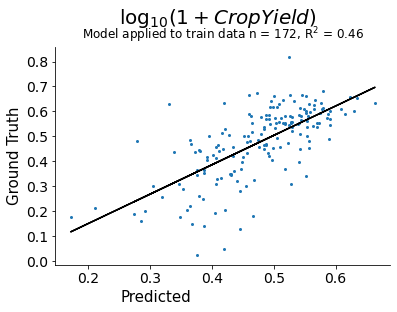

In [65]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()

In [66]:
r2_score(y_train, y_pred)

0.4620797727885608

In [67]:
pearsonr(y_pred, y_train)

(0.6876246542990719, 2.0508122832489461e-25)

In [68]:
spearmanr(y_pred, y_train)

SpearmanrResult(correlation=0.6950098785974366, pvalue=3.8490582506585045e-26)

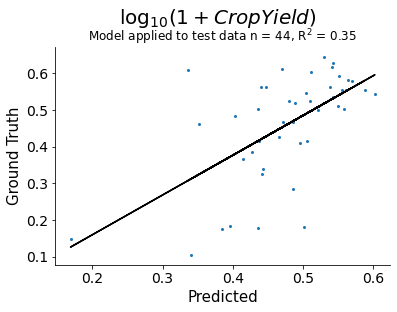

In [69]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [70]:
r2_score(y_test, y_pred)

0.35043227293445556

In [71]:
pearsonr(y_pred, y_test)

(0.6044226265538863, 1.3937073797540257e-05)

In [72]:
spearmanr(y_pred, y_test)

SpearmanrResult(correlation=0.5826638477801268, pvalue=3.3279303178502876e-05)

In [73]:
pred_features = features.copy()
x_all = pred_features.drop(['year', 'geometry', 'district', 'yield_mt'], axis = 1)
pred_features['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [74]:
plot_features = pred_features[pred_features.year == 2016]
# pred_features

<AxesSubplot:>

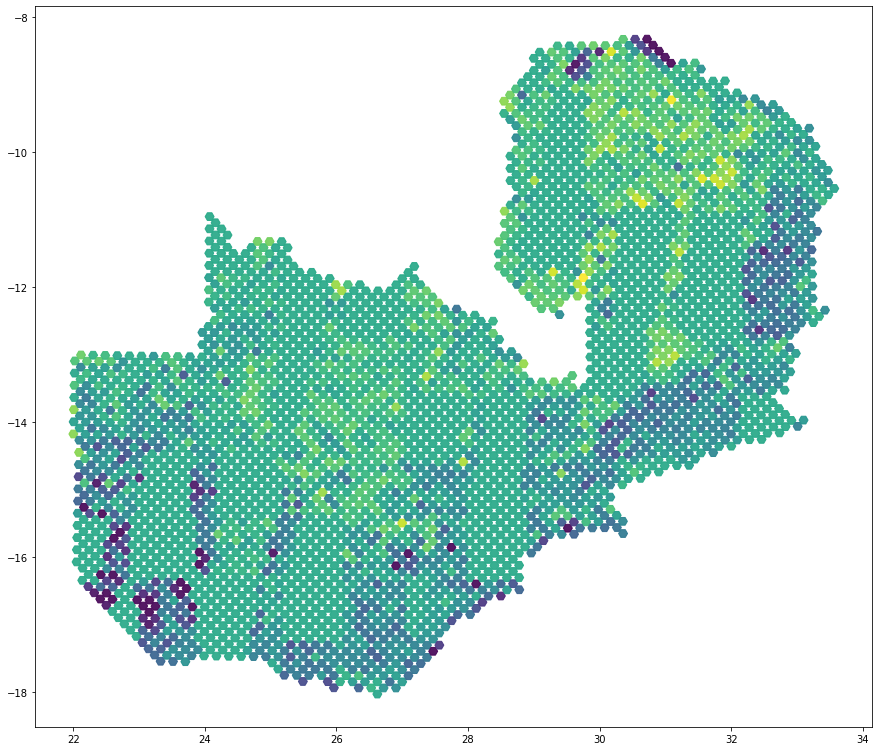

In [75]:
plot_features.plot(figsize = (15,15),
                   marker='H',
                   # legend = True,
                   markersize = 80,
                   alpha = .9,
                   column = 'fit')